# Object classification model using SIFT features

This notebook has two sections. Section 1 uses full images and extracts bounding boxes with manual coordinates and processes throug a SIFT histogram model. SVM and Logistic regression are used on train and validation sets for classfication. There is no data pre-processing or augmentation in this section. Section 2 uses already pre-processed and augmented bounding boxes as input data for training the SIFT model. This section also uses SVM and Logistic regression for classification.

In [1]:
# Install requied libraries
!python -m pip install --upgrade pip
!python -m pip install opencv-contrib-python --user
!python3.9 -m pip install seaborn

In [60]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import io
import json
import pandas as pd
import pickle
impost seaborn as sns

from PIL import Image
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.spatial import distance
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [65]:
# Set pwd
PWD = !pwd
PWD[0]

'/Users/vish/281/project'

In [66]:
# Set base dir
base_dir = PWD[0]

In [67]:
!pwd

/Users/vish/281/project


In [68]:
# Set the directory where all the pre-processed and augmented data is present
gray_dir = base_dir + "/gray_2/"
gray_dir

'/Users/vish/281/project/gray_2/'

In [5]:
#Define paths for full images and yolo bb files
image_dir = base_dir + "data/all_images/"
bbox_dir = base_dir + "data/yolofinalset/obj_train_data/"

#Change current directory
os.chdir(base_dir)

In [ ]:
# Load classes and input images from json files
with open(base_dir + "/classes.json") as infile:
    classes = json.load(infile)

with open(base_dir + "/train_test_split_img.json") as infile:
    inp_imgs = json.load(infile)

# Check keys of train_test_split_img.json
inp_imgs.keys()

### Section 1: Extract BB from images and no data augmentation or processing

In [11]:
# Function to extract a bounding box from the image 
# based on the yolo text file data

def extract_bbox(img, center_x, center_y, width, height):
    
    img_y, img_x = img.shape
    
    min_x = round((center_x - 0.5*width) * img_x)
    max_x = round((center_x + 0.5*width) * img_x)
    min_y = round((center_y - 0.5*height) * img_y)
    max_y = round((center_y + 0.5*height) * img_y)
    
    # return extracted bb
    return img[min_y:max_y, min_x:max_x]

In [795]:
# Function to extract all bounding boxes from a set of input images

def extract_all_bb(input_imgs, set_tag):
    """parameters: 
        input_imgs: input list of image names
        set_tag: "train" or "val" or "test"
        output: total bb count for input list 
    """
    # Initialize bb count for input set
    bb_cnt = 0

    # for each image get the yolo bb text file
    for image in input_imgs:
        img_path = image_dir + image
        bb_path = bbox_dir + image.replace('.jpg','.txt')


        # Convert ref image to grayscale
        img_color = plt.imread(img_path)
        img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
        
        # Open each yolo text and read all lines
        # yolov5 format - class_id center_x center_y width height
        with open(bb_path) as f:
            input_bb = f.readlines()


        # Assign values from yolo text file and extract bounding box
        for bb in range(len(input_bb)):
            cls, center_x, center_y, width, height = [float(x) for x in input_bb[bb].split()]
            
            #randomly generate bb variable name and assign extracted bb
            globals()['bb_%s_%s' % (set_tag, bb_cnt)] = [extract_bbox(img_gray, center_x, center_y, width, height),cls]
            
            # increment bb count
            bb_cnt += 1
    
    return bb_cnt

### Data assignment
* Get the list of tran, validation and test images from the input json
* Extract and store all bbs from the different input list
* The extrcted bbs and classes are stored in the global dictionary as a list [bb, cls]
* Variable format is bb_x_y where x is "train" or "val" or "test" ad y is the bb number in the list 

In [796]:
# Get the list of images
train_imgs = inp_imgs["X_train"]
val_imgs = inp_imgs["X_val"]
test_imgs = inp_imgs["X_test"]

# save bb and class for all sets
train_bbs = extract_all_bb(train_imgs, "train")
val_bbs = extract_all_bb(val_imgs, "val")
test_bbs = extract_all_bb(test_imgs, "test")

### Extract SIFT features from the training data and create histograms

In [797]:
# create SIFT feature extractor
sift = cv2.SIFT_create()

In [798]:
# function to get keypoints and descripors for the given list of bbs

def key_desc(bb_cnt, set_tag):
    """parameters: 
        bb_cnt: count of the input bbs
        set_tag: "train" or "val" or "test" 
    """
    
    # detect all keypoints, descriptors from all bbs
    for bb in range(bb_cnt):
        
        # Assign the keypoints and descriptors to predefined global variables using set tag
        globals()['kp_%s_%s' % (set_tag, bb)], globals()['dc_%s_%s' % (set_tag, bb)] \
                                = sift.detectAndCompute(globals()['bb_%s_%s' % (set_tag, bb)][0], None)
        
        # Assign classes to each bb to predefined global variables using set tag
        globals()['cl_%s_%s' % (set_tag, bb)] = int(globals()['bb_%s_%s' % (set_tag, bb)][1])
    
    return

Below we extract all keypoints and descriptors for the three different bb lists

In [799]:
# get all keypoints and descriptors
key_desc(train_bbs, "train")
key_desc(val_bbs, "val")
key_desc(test_bbs, "test")

Now that we have extracted all the keypoints and descriptors from the training bb list, we need to stack them up. This will help us run k-means on it and cluster them into different groups.

In [805]:
# function to stack all keypoint descriptors in a set

def dc_stack(bb_cnt, set_tag):
    """parameters: 
        bb_cnt: count of the input bbs
        set_tag: "train" or "val" or "test" 
        output: stacked descriptors (Nx128)
    """
        
    #stack all keypoint descriptors for using k-means later
    stack_dc = globals()['dc_%s_0' % (set_tag)]
    
    # Use try except for handling bbs with no keypoints or descriptors
    for i in range((bb_cnt)-1):
        try:
            stack_dc = np.vstack((stack_dc,globals()['dc_%s_%s' % (set_tag, i+1)]))
        except:
            pass
        
    return stack_dc

In [808]:
# stack all training keypoint descriptors by calling the function
train_dc = dc_stack(train_bbs, "train")

# check shape of stacked descriptors
print(train_dc.shape)

(191977, 128)


### K-means clustering
Run k-means algorithm on the extracted descriptors from the training set to form different clusters. Number of clusters is a hyper parameter arrived at after tuning.

In [809]:
# No of clusters/bins
dim = 350

# Instantiate k-means
kmeans = KMeans(init="k-means++", n_clusters=dim, n_init=4)

# Fit all training keypoints and transform
dc_km = kmeans.fit_transform(train_dc)

# Get cluster labels for the training keypoints
dc_kmy = kmeans.fit_predict(train_dc)

**Data validation - Perform some checks**

In [810]:
# Checks shapes of the transformed data
print("Shape of keypoint descriptors after clustering: ",dc_km.shape)
print("Shape of keypoint descriptor labels: ",dc_kmy.shape)

# min and max clusters
print("Minimum cluster #", min(dc_kmy), "Maximum cluster #", max(dc_kmy))

# Cluster identification for each keypoint

# Cluster centers shape
print("Cluster centers shape: ", kmeans.cluster_centers_.shape)

Shape of keypoint descriptors after clustering:  (191977, 350)
Shape of keypoint descriptor labels:  (191977,)
Minimum cluster # 0 Maximum cluster # 349
Cluster centers shape:  (350, 128)


**Building SIFT histogram for each bb based on the keypoint descriptor clusters**

In [811]:
# Function to build SIFT histogram from keypoint descriptors by grouping into clusters
def build_hist(bb_cnt, set_tag, dim):
    """parameters: 
        bb_cnt: count of the input bbs
        set_tag: "train" or "val" or "test"
        dim: number of clusters used as bins
    """
    # Use try except for handling bbs with no keypoints or descriptors
    for bb in range(bb_cnt): 
        try:
            # Run the bb keyponts through training kmeans 
            globals()['clst_%s_%s' % (set_tag, bb)] = kmeans.predict(globals()['dc_%s_%s' % (set_tag, bb)])
        except:
            # Set histogram to zero if there are no keypoints
            globals()['his_%s_%s' % (set_tag, bb)] = (np.zeros((dim,),dtype=int),np.arange(0,dim+1))
        else:
            # Create histogram based on assigned clusters when descriptors are available
            globals()['his_%s_%s' % (set_tag, bb)] = np.histogram(globals()['clst_%s_%s' % (set_tag, bb)], \
                                                                  bins=dim,range=(0,dim))
    
    return

**Building SIFT histograms for the training set**
<br/>The histogram is stored in a global variable of format is his_x_y where x is "train" or "val" or "test" ad y is the bb number in the list.

In [812]:
# Build SIFT histograms using clusters dimensions
build_hist(train_bbs, "train", dim)

In [813]:
# Check a value of the histogram and its bins
his_train_187

(array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [814]:
# Check value of the corresponding class label
cl_train_187

8

**Normalizing all the SIFT histograms by dividing with the max value**

In [817]:
# normalize histogram function

def hist_norm(bb_cnt, set_tag):
    """parameters: 
        bb_cnt: count of the input bbs
        set_tag: "train" or "val" or "test"
    """
    # for each bb, normalize the SIFT histogram by dividing the max value
    # use if else to avoid dividing by 0
    
    for bb in range(bb_cnt):
        
        if np.max(globals()['his_%s_%s' % (set_tag, bb)][0]) == 0:
            globals()['his_norm_%s_%s' % (set_tag, bb)] = \
              globals()['his_%s_%s' % (set_tag, bb)][0]
        else:
            globals()['his_norm_%s_%s' % (set_tag, bb)] = \
              globals()['his_%s_%s' % (set_tag, bb)][0]/np.max(globals()['his_%s_%s' % (set_tag, bb)][0])
        
    return

In [818]:
# normalizing train histograms
hist_norm(train_bbs, "train")

### Creating classification models
* Use the normalized SIFT histograms to train different linearly seperable (SVM and logistic regression) and simple L2 distance models
* Here we are going to use a One vs Rest classification model i.e. each class will be predicted with a yes or no when compared with all other classes

#### Training

In [819]:
# Get the normalized histograms and label data for the train set 
xtrain = [globals()['his_norm_train_%s' % bb] for bb in range(train_bbs)]
ytrain = [globals()['cl_train_%s' % bb] for bb in range(train_bbs)]

In [820]:
# Instantiate linear SVC and logistic regression models
lsvc = LinearSVC(penalty='l2', dual=False, multi_class = 'ovr', max_iter = 5000, C = 0.22, class_weight='balanced')
logovr = OneVsRestClassifier(LogisticRegression())

In [821]:
# Fit the training histograms and predict with SVC on training data itself
lsvc.fit(xtrain, ytrain)

y_train_score = lsvc.score(xtrain, ytrain)

print("SVC best score on Train set: {:.4f}".format(y_train_score))

SVC best score on Train set: 0.9311


In [828]:
# Fit the training histograms and predict with Logistic regression on training data itself 
logovr.fit(xtrain, ytrain)

y_train_pred = logovr.predict(xtrain)

print('LR Classifier best score on Train set: {:.4f}'.format(accuracy_score(ytrain, y_train_pred)))

LR Classifier best score on Train set: 0.9038


#### Validation

Check accuracy on validation set. Parameters were tuned using validation set performance.

In [823]:
# Function to build SIFT histogram from keypoint descriptors by grouping into clusters
def build_hist_val(desc, set_tag, dim, bb):
    """parameters:
        desc: keypoint descriptors variable for the input bb 
        set_tag: "train" or "val" or "test"
        dim: number of clusters used as bins
        bb: the index number of the bb from the list for which histogram is requested
    """
    
    # Use try except for handling bbs with no keypoints or descriptors
    try:
        # Run the bb keyponts through trained kmeans and assign clusters
        globals()['clst_%s_%s' % (set_tag, bb)] = kmeans.predict(desc)
    except:
        # Set histogram to zero if there are no keypoints
        globals()['his_%s_%s' % (set_tag, bb)] = (np.zeros((dim,),dtype=int),np.arange(0,dim+1))
    else:
        # Create histogram based on assigned clusters when descriptors are available for the bb
        globals()['his_%s_%s' % (set_tag, bb)] = np.histogram(globals()['clst_%s_%s' % (set_tag, bb)], \
                                                              bins=dim,range=(0,dim))
    
    return

In [824]:
# Build SIFT histogram for keypoints in each bb in the validation list
for bb in range(val_bbs):
    build_hist_val(globals()['dc_%s_%s' % ("val", bb)], "val", dim, bb)

In [825]:
# Normalize SIFT histograms from the validation bb list
for bb in range(val_bbs):
    
    # for each bb, normalize the SIFT histogram by dividing the max value
    # use if else to avoid dividing by 0
        
    if np.max(globals()['his_%s_%s' % ("val", bb)][0]) == 0:
            globals()['his_norm_%s_%s' % ("val", bb)] = \
              globals()['his_%s_%s' % ("val", bb)][0]
    else:
            globals()['his_norm_%s_%s' % ("val", bb)] = \
              globals()['his_%s_%s' % ("val", bb)][0]/np.max(globals()['his_%s_%s' % ("val", bb)][0])

In [827]:
# Get the normalized histograms and label data for the validation set 
xval = [globals()['his_norm_val_%s' % bb] for bb in range(val_bbs)]
yval = [globals()['cl_val_%s' % bb] for bb in range(val_bbs)]

In [830]:
# Predict with SVC on validation data
y_val_pred = lsvc.predict(xval)

print('SVC best score on Val set: {:.4f}'.format(accuracy_score(yval, y_val_pred)))

SVC best score on Val set: 0.7812


In [831]:
# Predict with SVC on validation data

y_val_pred = logovr.predict(xval)

print('LR Classifier best score on Val set: {:.2f}'.format(accuracy_score(yval, y_val_pred)))

LR Classifier best score on Val set: 0.75


Creating a third model to predict the class of the training SIFT histogram with the least L2 distance from validation sample

In [832]:
# Manual L2 distance check of SIFT histograms (Val vs Train)

# Create an empty list to store predictions
val_l2 = list()


# For each validation histogram check Euclidean distace with all training histograms and pick the least
for val in range(val_bbs):
    
    # Initialize the least distance and class label with first traing data
    lst_dist = distance.euclidean(xval[val],xtrain[0])
    cur_cls = yval[0]
    
    # Check the current validation histogram with every training histogram
    for train in range(train_bbs):
        
        # Calculate Euclidean distance
        cur_dist = distance.euclidean(xval[val],xtrain[train])
        
        # If the current distance is lower than the least one update least distance and current class
        if cur_dist < lst_dist:
            lst_dist = cur_dist
            cur_cls = ytrain[train]
    
    # Append the final class to prediction list 
    val_l2.append(cur_cls)

In [833]:
# Prediction score with manual L2 distance model on validation data

print('L2 dist Classifier best score on Val set: {:.4f}'.format(accuracy_score(yval, val_l2)))

L2 dist Classifier best score on Val set: 0.5596


### Section 2: Process using preprocessed and augmented data

In [7]:
# Load classes and augmented gray input images from json files
with open(base_dir +"/preproc_map_gray.json") as infile:
    gray_imgs = json.load(infile)

with open(base_dir+"/class_map_summary_gray.json") as infile:
    cls_summary_gray = json.load(infile)

In [8]:
# Check a key and value
print(list(gray_imgs.items())[0])

print("\n",list(cls_summary_gray.items())[0])

('000398_01_bb_cn_00_da_gray.jpg', {'image_source': '/images/apple/000398.jpg', 'bbox_source': '/yolofinalset/obj_train_data/000398.txt', 'preprocessing': ['bbox', 'cn', 'da', 'gray'], 'class': 'adidas', 'class_code': 0, 'set': 'train'})

 ('adidas', {'code': 0, 'num_bbs': 1528})


In [9]:
# Build a dataframe from class summary json for gray
cls_summary_gray = pd.DataFrame.from_dict(cls_summary_gray)
cls_summary_gray = cls_summary_gray.T

In [10]:
cls_summary_gray.head()

,code,num_bbs
adidas,0,1528
dhl,1,1528
apple,2,1528
bmw,3,1528
cocacola,4,1528


In [11]:
# Build a dataframe from gray pre-processed and augmented images json
gray_imgs = pd.DataFrame.from_dict(gray_imgs)
gray_imgs = gray_imgs.T
gray_imgs.head()

,image_source,bbox_source,preprocessing,class,class_code,set
000398_01_bb_cn_00_da_gray.jpg,/images/apple/000398.jpg,/yolofinalset/obj_train_data/000398.txt,"[bbox, cn, da, gray]",adidas,0,train
000398_01_bb_cn_01_da_gray.jpg,/images/apple/000398.jpg,/yolofinalset/obj_train_data/000398.txt,"[bbox, cn, da, gray]",adidas,0,train
000398_01_bb_cn_02_da_gray.jpg,/images/apple/000398.jpg,/yolofinalset/obj_train_data/000398.txt,"[bbox, cn, da, gray]",adidas,0,train
000398_01_bb_cn_03_da_gray.jpg,/images/apple/000398.jpg,/yolofinalset/obj_train_data/000398.txt,"[bbox, cn, da, gray]",adidas,0,train
000398_01_bb_cn_04_da_gray.jpg,/images/apple/000398.jpg,/yolofinalset/obj_train_data/000398.txt,"[bbox, cn, da, gray]",adidas,0,train


In [12]:
# Build dataframe of validation and test images from the contrast normalized folder
with open(base_dir +"/preproc_map_cn.json") as infile:
    cn_imgs = json.load(infile)

with open(base_dir+"/class_map_summary_cn.json") as infile:
    cls_summary_cn = json.load(infile)
    
cls_summary_cn = pd.DataFrame.from_dict(cls_summary_cn)
cls_summary_cn = cls_summary_cn.T
cls_summary_cn.head()

,code,num_bbs
adidas,0,264
dhl,1,317
apple,2,190
bmw,3,193
cocacola,4,263


In [13]:
# Build a dataframe from class summary json for contrast normalized images
cn_imgs = pd.DataFrame.from_dict(cn_imgs)
cn_imgs = cn_imgs.T

### Data assignment
* Get the list of tran, validation and test images from the dataframe created from input json

In [14]:
# Filter the train, validation and test file names based on the set names in gray and cn dataframes
train_set = gray_imgs[gray_imgs["set"]=="train"]
train_set = train_set.rename_axis('file').reset_index(level=0)
train_set = train_set.rename_axis('id').reset_index(level=0)

val_set = cn_imgs[cn_imgs["set"]=="val"]
val_set = val_set.rename_axis('file').reset_index(level=0)
val_set = val_set.rename_axis('id').reset_index(level=0)

test_set = cn_imgs[cn_imgs["set"]=="test"]
test_set = test_set.rename_axis('file').reset_index(level=0)
test_set = test_set.rename_axis('id').reset_index(level=0)

In [15]:
# Check a few rows in the train dataframe
train_set.head()

,id,file,image_source,bbox_source,preprocessing,class,class_code,set
0,0,000398_01_bb_cn_00_da_gray.jpg,/images/apple/000398.jpg,/yolofinalset/obj_train_data/000398.txt,"[bbox, cn, da, gray]",adidas,0,train
1,1,000398_01_bb_cn_01_da_gray.jpg,/images/apple/000398.jpg,/yolofinalset/obj_train_data/000398.txt,"[bbox, cn, da, gray]",adidas,0,train
2,2,000398_01_bb_cn_02_da_gray.jpg,/images/apple/000398.jpg,/yolofinalset/obj_train_data/000398.txt,"[bbox, cn, da, gray]",adidas,0,train
3,3,000398_01_bb_cn_03_da_gray.jpg,/images/apple/000398.jpg,/yolofinalset/obj_train_data/000398.txt,"[bbox, cn, da, gray]",adidas,0,train
4,4,000398_01_bb_cn_04_da_gray.jpg,/images/apple/000398.jpg,/yolofinalset/obj_train_data/000398.txt,"[bbox, cn, da, gray]",adidas,0,train


In [16]:
# Check a few rows in the val dataframe
val_set.head()

,id,file,image_source,bbox_source,preprocessing,class,class_code,set
0,0,006631_00_bb_cn.jpg,/images/starbucks/006631.jpg,/yolofinalset/obj_train_data/006631.txt,"[bbox, cn]",starbucks,8,val
1,1,006602_00_bb_cn.jpg,/images/starbucks/006602.jpg,/yolofinalset/obj_train_data/006602.txt,"[bbox, cn]",starbucks,8,val
2,2,006511_00_bb_cn.jpg,/images/starbucks/006511.jpg,/yolofinalset/obj_train_data/006511.txt,"[bbox, cn]",starbucks,8,val
3,3,006519_00_bb_cn.jpg,/images/starbucks/006519.jpg,/yolofinalset/obj_train_data/006519.txt,"[bbox, cn]",starbucks,8,val
4,4,006522_00_bb_cn.jpg,/images/starbucks/006522.jpg,/yolofinalset/obj_train_data/006522.txt,"[bbox, cn]",starbucks,8,val


In [17]:
# Check a few rows in the test dataframe
test_set.head()

,id,file,image_source,bbox_source,preprocessing,class,class_code,set
0,0,006618_00_bb_cn.jpg,/images/starbucks/006618.jpg,/yolofinalset/obj_train_data/006618.txt,"[bbox, cn]",starbucks,8,test
1,1,006618_01_bb_cn.jpg,/images/starbucks/006618.jpg,/yolofinalset/obj_train_data/006618.txt,"[bbox, cn]",starbucks,8,test
2,2,006618_02_bb_cn.jpg,/images/starbucks/006618.jpg,/yolofinalset/obj_train_data/006618.txt,"[bbox, cn]",starbucks,8,test
3,3,006617_00_bb_cn.jpg,/images/starbucks/006617.jpg,/yolofinalset/obj_train_data/006617.txt,"[bbox, cn]",starbucks,8,test
4,4,006494_00_bb_cn.jpg,/images/starbucks/006494.jpg,/yolofinalset/obj_train_data/006494.txt,"[bbox, cn]",starbucks,8,test


### Extract SIFT features from the training data and create histograms

In [18]:
# create SIFT feature extractor
sift_bb = cv2.SIFT_create()

In [19]:
# function to get keypoints and descripors for the given list of bbs
def key_desc_bb(file):
    """parameters: 
        file: input bb file name
        output: returns descriptors of keypoints
    """
    img_gray = plt.imread(gray_dir + file)
    
    kp, dc = sift_bb.detectAndCompute(img_gray, None)
    
    return dc

Below we extract all keypoints and descriptors for the three different bb lists

In [20]:
# Add a column to train dataframe and store all the keypoint descriptors for the corresponding files
train_set['kp_dc'] = train_set['file'].apply(key_desc_bb)

In [21]:
# Save the dataframe to pickle object for future use
pkl_obj = open('train_set.pkl', 'wb')
pickle.dump(train_set,pkl_obj)
pkl_obj.close()

Now that we have extracted all the keypoints and descriptors from the training list, we need to stack them up. This will help us run k-means on it and cluster them into different groups.

In [22]:
# Stack all keypoint descriptors from all data skipping BBs with no keypoints
# This is to build clusters (BOW) and to build SIFT histogram
stack_desc = np.vstack(train_set[train_set['kp_dc'].apply(lambda x: x is not None)]['kp_dc'])

In [23]:
# Check shape of the stacked descriptors
stack_desc.shape

(1514473, 128)

In [24]:
# Check shape of the descriptors of one of the files
train_set['kp_dc'][1100].shape

(730, 128)

### K-means clustering
Run k-means algorithm on the extracted descriptors from the training set to form different clusters. Number of clusters is a hyper parameter arrived at after tuning.

In [25]:
# Define number of clusters/bins
dim = 1500

# Instantiate k-means
kmeans = KMeans(init="k-means++", n_clusters=dim, n_init=3)

# Fit all training keypoints and transform
dc_km = kmeans.fit_transform(stack_desc)

# Get cluster labels for the training keypoints
dc_kmy = kmeans.fit_predict(stack_desc)

In [26]:
# Save the kmeans to pickle object for future use
pkl_obj = open('kmeans.pkl', 'wb')
pickle.dump(kmeans,pkl_obj)
pkl_obj.close()

pkl_obj = open('dc_km.pkl', 'wb')
pickle.dump(dc_km,pkl_obj)
pkl_obj.close()

pkl_obj = open('dc_kmy.pkl', 'wb')
pickle.dump(dc_kmy,pkl_obj)
pkl_obj.close()

In [27]:
# Check the shape of the descriptors after kmeans
# Number of features will be based on the bins
dc_km.shape

(1514473, 1500)

In [28]:
# Check the shape of the cluster labels for the training keypoint descriptors
dc_kmy.shape

(1514473,)

In [29]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 01:23:50


Building SIFT histogram for each bb based on the keypoint descriptor clusters

In [30]:
# Add a new column and store the created SIFT histogram
train_set["sift_hist"] = train_set[train_set['kp_dc'].apply(lambda x: x is not None)]['kp_dc']\
                        .apply(lambda x: kmeans.predict(x))\
                            .apply(lambda x: np.histogram(x,bins = 1500, range = (0,1500)))

In [31]:
# Save the updated dataframe with SIFT histogram as a pickle object
pkl_obj = open('train_set.pkl', 'wb')
pickle.dump(train_set,pkl_obj)
pkl_obj.close()

Normalize the SIFT histograms

In [32]:
# Perform normalization on the SIFT histograms and add it to a new column
train_set["norm_hist"] = train_set[train_set['sift_hist'].apply(lambda x: type(x) is tuple)]['sift_hist']\
                        .apply(lambda x: x[0]/np.max(x[0]))

In [33]:
# Save the updated dataframe with SIFT histogram as a pickle object
pkl_obj = open('train_set.pkl', 'wb')
pickle.dump(train_set,pkl_obj)
pkl_obj.close()

### Training

In [34]:
# Get the normalized histograms and label data for the train set 
xtrain = list(train_set[train_set['sift_hist'].apply(lambda x: type(x) is tuple)]['norm_hist'])
ytrain = list(train_set[train_set['sift_hist'].apply(lambda x: type(x) is tuple)]['class_code'])

In [ ]:
#xtrain[xtrain.apply(lambda x: np.isnan(np.isnan(np.sum(x))))]

Train a SVC and a Logistic regression model

In [35]:
# Instantiate linear SVC and logistic regression models
lsvc = LinearSVC(penalty='l2', dual=False, multi_class = 'ovr', max_iter = 5000, C = 0.01, class_weight='balanced')
logovr = OneVsRestClassifier(LogisticRegression(penalty='l2', multi_class = 'ovr',\
                                                solver='liblinear',C = 0.1, max_iter = 5000))

In [36]:
# Fit the training histograms and predict with SVC on training data itself
lsvc.fit(xtrain, ytrain)

y_train_score = lsvc.score(xtrain, ytrain)

print("SVC best score on Train set: {:.4f}".format(y_train_score))

SVC best score on Train set: 0.8856


In [37]:
# Fit the training histograms and predict with Logistic regression on training data itself 
logovr.fit(xtrain, ytrain)

y_train_pred = logovr.predict(xtrain)

print('LR Classifier best score on Train set: {:.4f}'.format(accuracy_score(ytrain, y_train_pred)))

LR Classifier best score on Train set: 0.8797


Perform the same set of steps on the validation files to extract keypoint descriptors, predict using the prevously trained kmeans model, build SIFT histogram, normalized and then predict using the previously trained SVC and Logistic Regression models. 

In [38]:
# function to get keypoints and descripors for the given list of bbs

def key_desc_bb_cn(file):
    """parameters: 
        file: input bb file name 
        output: returns keypoint descriptors
    """
    img_clr = plt.imread(base_dir + '/cn/' + file)
    gray = cv2.cvtColor(img_clr, cv2.COLOR_BGR2GRAY)
    
    kp, dc = sift_bb.detectAndCompute(gray, None)
    
    return dc

**Results on Val set**

In [39]:
# Add a column to val dataframe and store all the keypoint descriptors for the corresponding files
val_set['kp_dc'] = val_set['file'].apply(key_desc_bb_cn)

In [40]:
# predict using the prevously trained kmeans model and assign clusters
val_set['kp_dc_cls'] = val_set[val_set['kp_dc'].apply(lambda x: x is not None)]['kp_dc']\
                            .apply(lambda x : kmeans.predict(x))

In [41]:
# Add a new column and store the created SIFT histogram
val_set["sift_hist"] = val_set[val_set['kp_dc'].apply(lambda x: x is not None)]['kp_dc_cls']\
                        .apply(lambda x: np.histogram(x,bins = 1500, range = (0,1500)))

In [42]:
# Perform normalization on the SIFT histograms and add it to a new column
val_set["norm_hist"] = val_set[val_set['sift_hist'].apply(lambda x: type(x) is tuple)]['sift_hist']\
                        .apply(lambda x: x[0]/np.max(x[0]))

In [43]:
# Save the updated dataframe with SIFT histogram as a pickle object
pkl_obj = open('val_set.pkl', 'wb')
pickle.dump(val_set,pkl_obj)
pkl_obj.close()

In [44]:
# Get the normalized histograms and label data for the val set 
xval = list(val_set[val_set['sift_hist'].apply(lambda x: type(x) is tuple)]['norm_hist'])
yval = list(val_set[val_set['sift_hist'].apply(lambda x: type(x) is tuple)]['class_code'])

In [47]:
# Predict val set using previously trained SVC model

y_val_score = lsvc.score(xval, yval)

print("SVC best score on Val set: {:.4f}".format(y_val_score))

SVC best score on Val set: 0.7667


In [48]:
# Predict val set using previously trained Logistic Regression model

y_val_pred = logovr.predict(xval)

print('LR Classifier best score on Val set: {:.4f}'.format(accuracy_score(yval, y_val_pred)))

LR Classifier best score on Val set: 0.7556


In [49]:
# Save the validation dataframe
pkl_obj = open('val_set.pkl', 'wb')
pickle.dump(val_set,pkl_obj)
pkl_obj.close()

**Results on Test Set**

In [50]:
# Add a column to test dataframe and store all the keypoint descriptors for the corresponding files
test_set['kp_dc'] = test_set['file'].apply(key_desc_bb_cn)

In [51]:
# predict using the prevously trained kmeans model and assign clusters
test_set['kp_dc_cls'] = test_set[test_set['kp_dc'].apply(lambda x: x is not None)]['kp_dc']\
                            .apply(lambda x : kmeans.predict(x))

In [52]:
# Add a new column and store the created SIFT histogram
test_set["sift_hist"] = test_set[test_set['kp_dc'].apply(lambda x: x is not None)]['kp_dc_cls']\
                        .apply(lambda x: np.histogram(x,bins = 1500, range = (0,1500)))

In [53]:
# Perform normalization on the SIFT histograms and add it to a new column
test_set["norm_hist"] = test_set[test_set['sift_hist'].apply(lambda x: type(x) is tuple)]['sift_hist']\
                        .apply(lambda x: x[0]/np.max(x[0]))

In [54]:
# Save the updated dataframe with SIFT histogram as a pickle object
pkl_obj = open('test_set.pkl', 'wb')
pickle.dump(test_set,pkl_obj)
pkl_obj.close()

In [55]:
# Get the normalized histograms and label data for the test set 
xtest = list(test_set[test_set['sift_hist'].apply(lambda x: type(x) is tuple)]['norm_hist'])
ytest = list(test_set[test_set['sift_hist'].apply(lambda x: type(x) is tuple)]['class_code'])

In [56]:
# Predict test set using previously trained SVC model

y_test_score = lsvc.score(xtest, ytest)

print("SVC best score on Test set: {:.4f}".format(y_test_score))

SVC best score on Test set: 0.7529


In [57]:
# Predict val set using previously trained Logistic Regression model

y_test_pred = logovr.predict(xtest)

print('LR Classifier best score on Test set: {:.4f}'.format(accuracy_score(ytest, y_test_pred)))

LR Classifier best score on Test set: 0.7413


In [58]:
# Save the updated dataframe with SIFT histogram as a pickle object
pkl_obj = open('test_set.pkl', 'wb')
pickle.dump(test_set,pkl_obj)
pkl_obj.close()

**Build ROC Curve for the classes**
The below One vs Rest classification ROC curves code is based on this [source](https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb).

In [75]:
# Build ROC Curve
y_pred_proba = logovr.predict_proba(xtest)[::,1]

In [77]:
xtest = (test_set[test_set['sift_hist'].apply(lambda x: type(x) is tuple)]['norm_hist'])
ytest = (test_set[test_set['sift_hist'].apply(lambda x: type(x) is tuple)]['class_code'])

In [63]:
classes = logovr.classes_
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [107]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) 
    based on real and predicted observations
    Parameters:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
    Output:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr


In [108]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a 
    threshold for the predicion of the class.
    Parameters:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Output:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    return tpr_list, fpr_list

In [123]:
def roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    Parameters:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

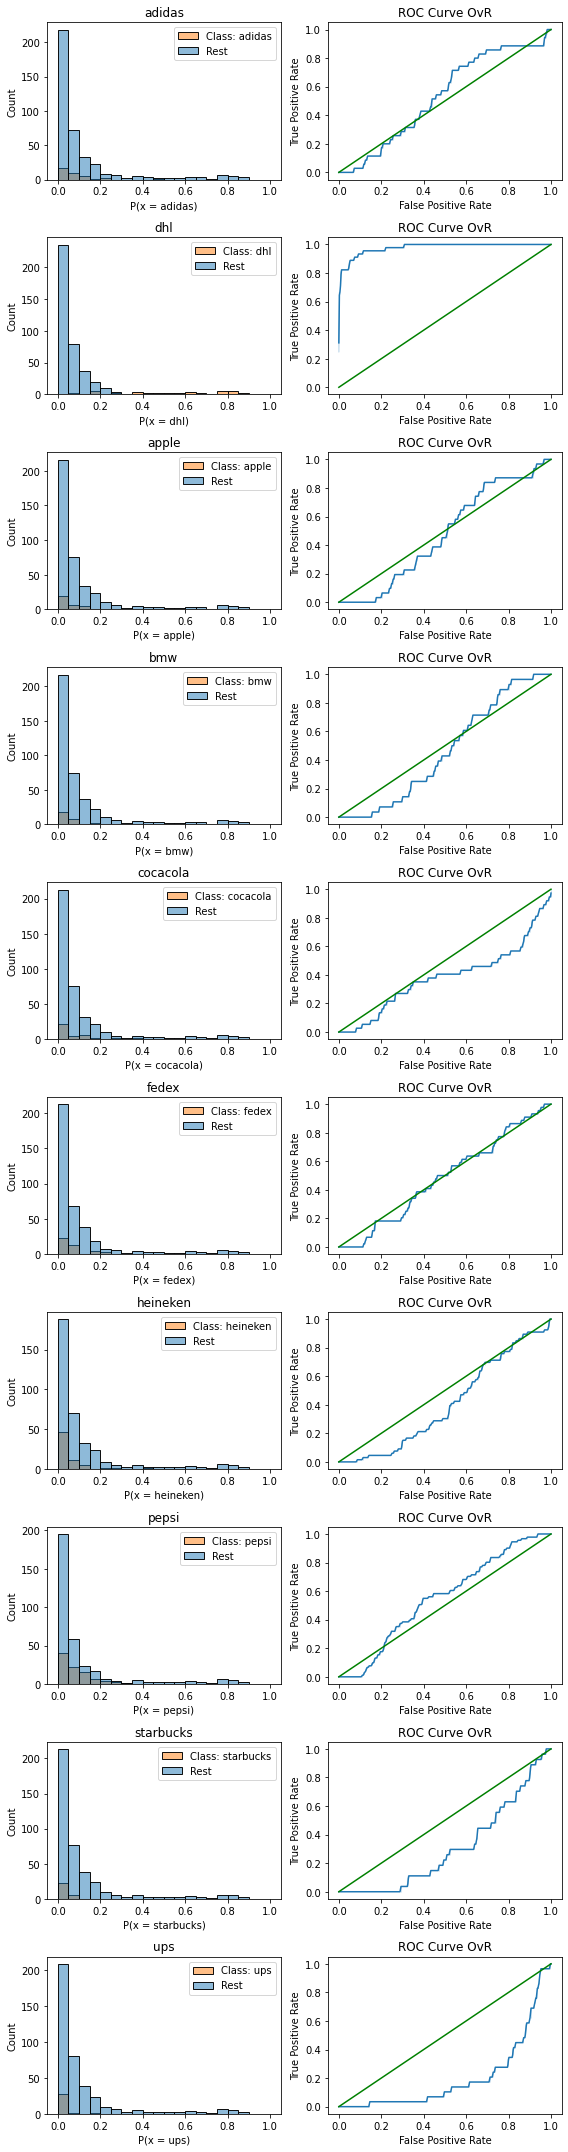

In [128]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (8, 30))
bins = [i/20 for i in range(20)] + [1]
roc_ovr = {}

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares a dataframe to help with the plots
    plt_df = xtest.copy()
    plt_df['class'] = [1 if y == c else 0 for y in ytest]
    plt_df['prob'] = y_pred_proba
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(10, 2, 2*i+1)
    sns.histplot(x = "prob", data = plt_df, hue = 'class', color = 'amber', alpha = 0.5, ax = ax, bins = bins)
    ax.set_title(cls_summary_cn.code[cls_summary_cn.code == c].index.tolist()[0])
    ax.legend([f"Class: {cls_summary_cn.code[cls_summary_cn.code == c].index.tolist()[0]}", "Rest"])
    ax.set_xlabel(f"P(x = {cls_summary_cn.code[cls_summary_cn.code == c].index.tolist()[0]})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(10, 2, 2*i+2)
    tpr, fpr = get_all_roc_coordinates(plt_df['class'], plt_df['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_ovr[c] = roc_auc_score(plt_df['class'], plt_df['prob'])
    
plt.tight_layout()